# **Super Resolution GAN (SRGAN) for Enhancing Imagery**

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

Used the DVI2K dataset from: "https://data.vision.ee.ethz.ch/cvl/DIV2K/"

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip DIV2K_train_HR.zip


--2024-10-07 09:28:43--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2024-10-07 09:28:44--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip.1’

DIV2K_train_HR.zip. 100%[===================>]   3.29G  22.3MB/s    in 2m 29s  

2024-10-07 09:31:13 (22.6 MB/s) - ‘DIV2K_train_HR.zip.1’ saved [3530603713/3530603713]

Archive:  DIV2K_train_HR.zip
   creating: DIV2K_train_HR/
  inflating: DIV2K_train_HR/0103.png  
  inflating: DI

## Preparing low res data

In [ ]:
def create_low_res_images(high_res_dir, low_res_dir, scale=4):
    os.makedirs(low_res_dir, exist_ok=True)
    for filename in os.listdir(high_res_dir):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(high_res_dir, filename))
            low_res = cv2.resize(img, (img.shape[1] // scale, img.shape[0] // scale), interpolation=cv2.INTER_CUBIC)
            cv2.imwrite(os.path.join(low_res_dir, filename), low_res)

# Directories
high_res_dir = 'DIV2K_train_HR'
low_res_dir = 'DIV2K_train_LR'

# Create low-res images
create_low_res_images(high_res_dir, low_res_dir)


## Building the SRGAN generator

In [ ]:
class ResidualBlock(tf.keras.Model):
    def __init__(self):
        super(ResidualBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')
        self.relu = tf.keras.layers.ReLU()

    def call(self, x):
        res = x
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return x + res  # Residual connection


class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.initial_conv = tf.keras.layers.Conv2D(64, kernel_size=9, padding='same')
        self.residual_blocks = [ResidualBlock() for _ in range(16)]
        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')
        self.upsample1 = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')
        self.upsample2 = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')
        self.final_conv = tf.keras.layers.Conv2D(3, kernel_size=9, padding='same')

    def call(self, x):
        x = self.initial_conv(x)
        for res_block in self.residual_blocks:
            x = res_block(x)
        x = self.conv1(x)
        x = self.upsample1(x)
        x = self.upsample2(x)
        return self.final_conv(x)


## Building the SRGAN descriminator

In [ ]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same')
        self.conv3 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same')
        self.conv4 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same')
        self.flatten = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(1)

    def call(self, x):
        x = tf.keras.layers.LeakyReLU()(self.conv1(x))
        x = tf.keras.layers.LeakyReLU()(self.conv2(x))
        x = tf.keras.layers.LeakyReLU()(self.conv3(x))
        x = tf.keras.layers.LeakyReLU()(self.conv4(x))
        x = self.flatten(x)
        return tf.sigmoid(self.fc(x))


## Loss function / Optimizer

In [ ]:
def content_loss(y_true, y_pred):
    return tf.reduce_mean(tf.keras.losses.MeanSquaredError()(y_true, y_pred))

def adversarial_loss(y_true, y_pred):
    return tf.reduce_mean(tf.keras.losses.BinaryCrossentropy()(y_true, y_pred))

generator = Generator()
discriminator = Discriminator()

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


## Training the SRGAN

In [ ]:
import glob
import numpy as np
import tensorflow as tf
from PIL import Image
import time
import os

# Load dataset
low_res_images = glob.glob(os.path.join(low_res_dir, '*.png'))  # Load all PNG files
high_res_images = glob.glob(os.path.join(high_res_dir, '*.png'))

EPOCHS = 10  # Increase for better results
BATCH_SIZE = 16

@tf.function
def train_step(low_res_batch, high_res_batch):
    with tf.GradientTape(persistent=True) as tape:
        generated_images = generator(low_res_batch, training=True)
        real_output = discriminator(high_res_batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = content_loss(high_res_batch, generated_images) + adversarial_loss(tf.ones_like(fake_output), fake_output)
        disc_loss = adversarial_loss(tf.ones_like(real_output), real_output) + adversarial_loss(tf.zeros_like(fake_output), fake_output)

    generator_gradients = tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

# Training Loop
for epoch in range(EPOCHS):
    for i in range(0, len(low_res_images), BATCH_SIZE):
        low_res_batch = []
        high_res_batch = []

        start_time = time.time()  # Start timing
        for j in range(BATCH_SIZE):
            if i + j >= len(low_res_images):
                break
            # Load images using Pillow
            low_res_img = Image.open(low_res_images[i + j]).convert('RGB')
            high_res_img = Image.open(high_res_images[i + j]).convert('RGB')

            low_res_batch.append(np.array(low_res_img.resize((64, 64))))
            high_res_batch.append(np.array(high_res_img.resize((256, 256))))

        low_res_batch = np.array(low_res_batch) / 255.0
        high_res_batch = np.array(high_res_batch) / 255.0

        train_step(low_res_batch, high_res_batch)

        print(f"Processed batch {i // BATCH_SIZE + 1}/{len(low_res_images) // BATCH_SIZE + 1} in {time.time() - start_time:.2f} seconds.")

    print(f'Epoch {epoch + 1}/{EPOCHS} completed.')


Processed batch 1/51 in 6.95 seconds.
Processed batch 2/51 in 2.81 seconds.
Processed batch 3/51 in 2.46 seconds.
Processed batch 4/51 in 2.49 seconds.
Processed batch 5/51 in 2.32 seconds.
Processed batch 6/51 in 3.16 seconds.
Processed batch 7/51 in 2.71 seconds.
Processed batch 8/51 in 2.34 seconds.
Processed batch 9/51 in 2.31 seconds.
Processed batch 10/51 in 2.27 seconds.
Processed batch 11/51 in 2.67 seconds.
Processed batch 12/51 in 2.99 seconds.
Processed batch 13/51 in 2.42 seconds.
Processed batch 14/51 in 2.48 seconds.
Processed batch 15/51 in 2.30 seconds.
Processed batch 16/51 in 2.57 seconds.
Processed batch 17/51 in 3.04 seconds.
Processed batch 18/51 in 2.45 seconds.
Processed batch 19/51 in 2.43 seconds.
Processed batch 20/51 in 2.46 seconds.
Processed batch 21/51 in 2.91 seconds.
Processed batch 22/51 in 2.85 seconds.
Processed batch 23/51 in 2.47 seconds.
Processed batch 24/51 in 2.42 seconds.
Processed batch 25/51 in 2.28 seconds.
Processed batch 26/51 in 2.87 seco

## Result evaluation and visualization

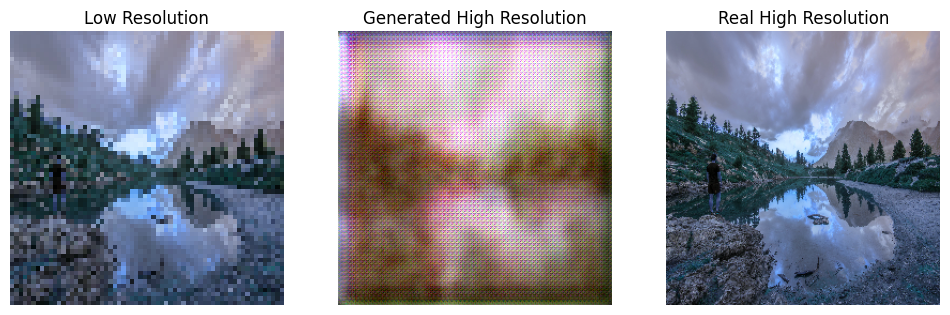

In [ ]:
def visualize_results(low_res_image, generated_image, high_res_image):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Low Resolution")
    plt.imshow(low_res_image)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Generated High Resolution")
    plt.imshow(generated_image)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Real High Resolution")
    plt.imshow(high_res_image)
    plt.axis("off")

    plt.show()

# Example of visualizing a result
example_low_res = cv2.imread(low_res_images[0])
example_high_res = cv2.imread(high_res_images[0])

example_low_res = cv2.resize(example_low_res, (64, 64)) / 255.0
example_high_res = cv2.resize(example_high_res, (256, 256)) / 255.0

generated_image = generator(tf.convert_to_tensor(example_low_res[None, ...], dtype=tf.float32)).numpy()[0]

visualize_results(example_low_res, generated_image, example_high_res)
